<a href="https://colab.research.google.com/github/MostafaJahanian/Free_Projects/blob/main/CIFAR10_Dataset_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random

### Loading Dataset From Keras 

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 14s 0us/step


In [3]:
train_images.shape, test_images.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [4]:
len(np.unique(train_labels))

10

In [5]:
# copied from keras api
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog' ,'frog', 'horse', 'ship' ,'truck']

### Getting Data Ready for Training

In [6]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.1, shuffle = True, random_state = 1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((45000, 32, 32, 3), (45000, 1), (5000, 32, 32, 3), (5000, 1))

In [7]:
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = test_labels.flatten()

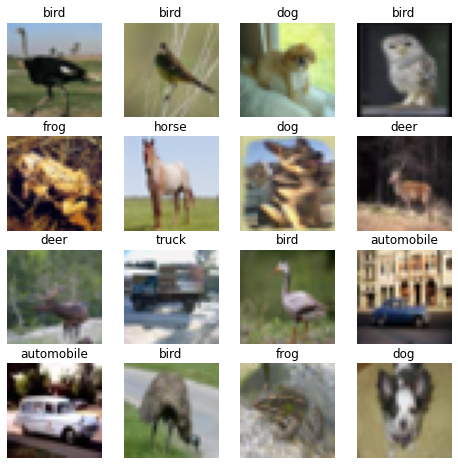

In [8]:
# plotting random images from the train data
plt.figure(figsize = (8, 8))
for i in range(16):
  index = random.randint(0, len(X_train))
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X_train[index])
  plt.title(class_names[y_train[index]])
  plt.axis(False)

In [9]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(len(X_train), 32*32*3)).reshape(X_train.shape)
X_train_scaled.shape

(45000, 32, 32, 3)

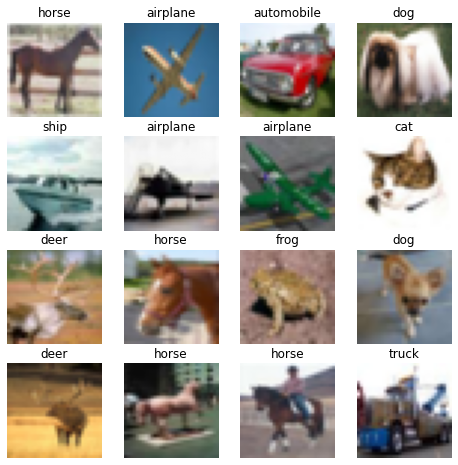

In [10]:
# plotting random images from the normalized train data
plt.figure(figsize = (8, 8))
for i in range(16):
  index = random.randint(0, len(X_train_scaled))
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X_train_scaled[index])
  plt.title(class_names[y_train[index]])
  plt.axis(False)

In [11]:
X_val_scaled = scaler.transform(X_val.reshape(len(X_val), 32*32*3)).reshape(X_val.shape)
X_test_scaled = scaler.transform(test_images.reshape(len(test_images), 32*32*3)).reshape(test_images.shape)
X_val_scaled.shape, X_test_scaled.shape

((5000, 32, 32, 3), (10000, 32, 32, 3))

### Training CNN on the Data

Model 1:

--- Conv2D layer, 40 filters of size 3, same padding, relu activation

--- MaxPooling2D layer, pool size = 2

--- Flatten layer

--- Dense layer, 500 units, relu activation

--- Dense layer, Output, 10 units, softmax activation

--- Adam optimzier, default learning rate

--- 20 epochs

In [16]:
tf.random.set_seed(42)

cnn_1 = keras.Sequential([
    layers.Conv2D(filters = 40, kernel_size = 3, padding = 'same', input_shape = (32, 32, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])

cnn_1.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_1 = cnn_1.fit(X_train_scaled, y_train, epochs = 20, validation_data = (X_val_scaled, y_val))

Epoch 1/20
1407/1407 [==============================] - 17s 4ms/step - loss: 1.4246 - accuracy: 0.4935 - val_loss: 1.2031 - val_accuracy: 0.5784
Epoch 2/20
1407/1407 [==============================] - 6s 4ms/step - loss: 1.1018 - accuracy: 0.6125 - val_loss: 1.0816 - val_accuracy: 0.6150
Epoch 3/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9518 - accuracy: 0.6646 - val_loss: 1.0456 - val_accuracy: 0.6294
Epoch 4/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8134 - accuracy: 0.7131 - val_loss: 1.0195 - val_accuracy: 0.6512
Epoch 5/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6876 - accuracy: 0.7571 - val_loss: 1.0597 - val_accuracy: 0.6434
Epoch 6/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5710 - accuracy: 0.8004 - val_loss: 1.0320 - val_accuracy: 0.6620
Epoch 7/20
1407/1407 [==============================] - 7s 5ms/step - loss: 0.4583 - accuracy: 0.8396 - val_loss: 1.1250 - val_accuracy

In [47]:
def plot_training_curve(history_df):
  plt.figure(figsize = (6.5, 4), dpi = 120)
  plt.plot(range(1, len(history_df) + 1), history_df['loss'], marker = '.', label = 'Training Loss')
  plt.plot(range(1, len(history_df) + 1), history_df['val_loss'], marker = '.', label = 'Validation Loss')
  plt.plot(range(1, len(history_df) + 1), history_df['accuracy'], marker = '>', label = 'Training Accuracy')
  plt.plot(range(1, len(history_df) + 1), history_df['val_accuracy'], marker = '>', label = 'Validation Accurcay')
  plt.xlabel('Epoch')
  plt.title('Training Curve')
  plt.grid()
  plt.legend()
  plt.show()

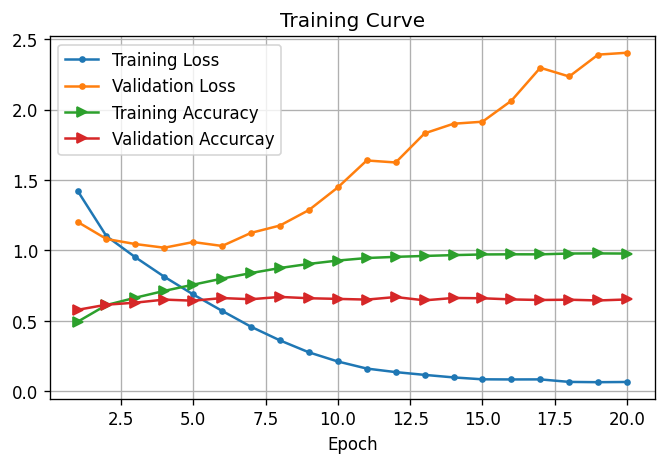

In [48]:
plot_training_curve(pd.DataFrame(history_1.history))

--- Based on the plots above, this model is overfitted as validation curves do not follow those of training. Aiming to tackle this, Dropout layer will be added to the model.

Model 2:

--- Conv2D layer, 40 filters of size 3, same padding, relu activation

--- MaxPooling2D layer, pool size = 2

--- Flatten layer

--- **Dropout layer of rate 0.3**

--- Dense layer, 500 units, relu activation

--- Dense layer, Output, 10 units, softmax activation

--- Adam optimzier, default learning rate

--- 20 epochs

In [32]:
tf.random.set_seed(42)

cnn_2 = keras.Sequential([
    layers.Conv2D(filters = 40, kernel_size = 3, padding = 'same', input_shape = (32, 32, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])

cnn_2.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_2 = cnn_2.fit(X_train_scaled, y_train, epochs = 20, validation_data = (X_val_scaled, y_val))

Epoch 1/20
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4551 - accuracy: 0.4825 - val_loss: 1.2295 - val_accuracy: 0.5726
Epoch 2/20
1407/1407 [==============================] - 6s 4ms/step - loss: 1.1499 - accuracy: 0.5921 - val_loss: 1.1070 - val_accuracy: 0.6066
Epoch 3/20
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0172 - accuracy: 0.6393 - val_loss: 1.0805 - val_accuracy: 0.6144
Epoch 4/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9050 - accuracy: 0.6801 - val_loss: 1.0934 - val_accuracy: 0.6224
Epoch 5/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7967 - accuracy: 0.7178 - val_loss: 1.0045 - val_accuracy: 0.6502
Epoch 6/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7081 - accuracy: 0.7492 - val_loss: 1.0049 - val_accuracy: 0.6570
Epoch 7/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6190 - accuracy: 0.7803 - val_loss: 1.0186 - val_accuracy:

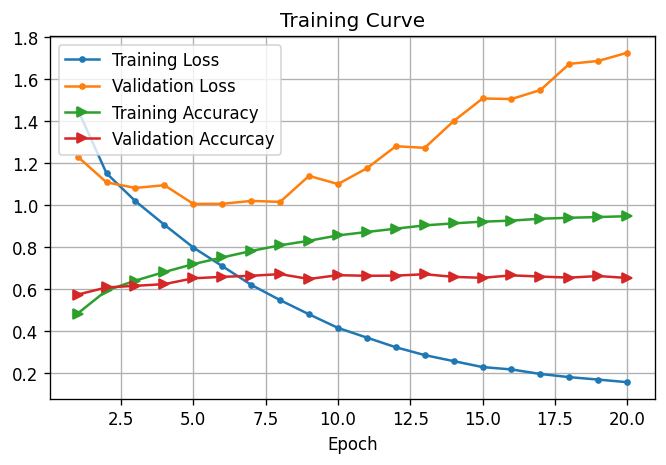

In [49]:
plot_training_curve(pd.DataFrame(history_2.history))

--- Although the second model improved to some extent, specially regarding loss curve, it is not no way near satisfactory.

Model 3:

--- Conv2D layer, 40 filters of size 3, same padding, relu activation

--- MaxPooling2D layer, pool size = 2

--- **Conv2D layer, 20 filters of size 2, same padding, relu activation**

--- **MaxPooling2D layer of pool size 2**

--- Flatten layer

--- Dropout layer of rate 0.3

--- Dense layer, 500 units, relu activation

--- Dense layer, Output, 10 units, softmax activation

--- Adam optimzier, default learning rate

--- 20 epochs

In [36]:
tf.random.set_seed(42)

cnn_3 = keras.Sequential([
    layers.Conv2D(filters = 40, kernel_size = 3, padding = 'same', input_shape = (32, 32, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 20, kernel_size = 2, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])

cnn_3.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_3 = cnn_3.fit(X_train_scaled, y_train, epochs = 20, validation_data = (X_val_scaled, y_val))

Epoch 1/20
1407/1407 [==============================] - 7s 4ms/step - loss: 1.4757 - accuracy: 0.4688 - val_loss: 1.2304 - val_accuracy: 0.5662
Epoch 2/20
1407/1407 [==============================] - 6s 4ms/step - loss: 1.1643 - accuracy: 0.5862 - val_loss: 1.0757 - val_accuracy: 0.6186
Epoch 3/20
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0268 - accuracy: 0.6368 - val_loss: 0.9468 - val_accuracy: 0.6658
Epoch 4/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9151 - accuracy: 0.6771 - val_loss: 0.9491 - val_accuracy: 0.6744
Epoch 5/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8197 - accuracy: 0.7124 - val_loss: 0.9344 - val_accuracy: 0.6710
Epoch 6/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7407 - accuracy: 0.7404 - val_loss: 0.8460 - val_accuracy: 0.7104
Epoch 7/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6715 - accuracy: 0.7631 - val_loss: 0.8226 - val_accuracy:

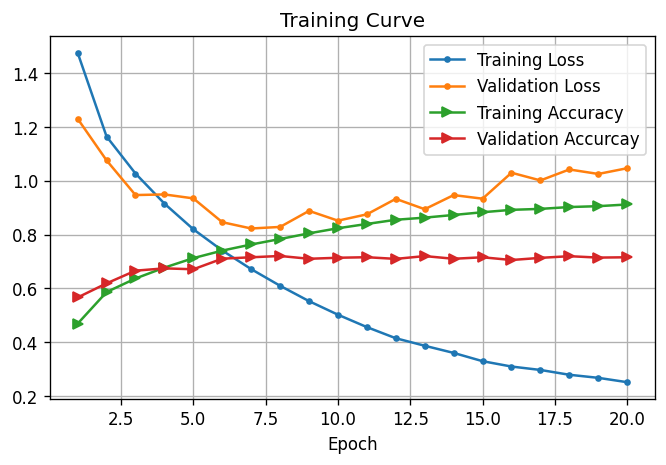

In [50]:
plot_training_curve(pd.DataFrame(history_3.history))

--- Adding another Conv2D layer along with a MaxPooling2D, resulted in a significant improvement of the model. Now adding another *Dropout* layer may help with achieving the result we want.

Model 4:

--- Conv2D layer, 40 filters of size 3, same padding, relu activation

--- MaxPooling2D layer, pool size = 2

--- Conv2D layer, 20 filters of size 2, same padding, relu activation

--- MaxPooling2D layer of pool size 2

--- Flatten layer

--- Dropout layer of rate 0.3

--- Dense layer, 500 units, relu activation

--- Dropout layer of rate 0.3

--- Dense layer, Output, 10 units, softmax activation

--- Adam optimzier, default learning rate

--- 20 epochs

In [52]:
tf.random.set_seed(42)

cnn_4 = keras.Sequential([
    layers.Conv2D(filters = 40, kernel_size = 3, padding = 'same', input_shape = (32, 32, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 20, kernel_size = 2, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(500, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation = 'softmax')
])

cnn_4.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_4 = cnn_4.fit(X_train_scaled, y_train, epochs = 20, validation_data = (X_val_scaled, y_val))

Epoch 1/20
1407/1407 [==============================] - 7s 4ms/step - loss: 1.5236 - accuracy: 0.4510 - val_loss: 1.2167 - val_accuracy: 0.5770
Epoch 2/20
1407/1407 [==============================] - 6s 4ms/step - loss: 1.2205 - accuracy: 0.5665 - val_loss: 1.0901 - val_accuracy: 0.6144
Epoch 3/20
1407/1407 [==============================] - 6s 4ms/step - loss: 1.1046 - accuracy: 0.6097 - val_loss: 0.9898 - val_accuracy: 0.6526
Epoch 4/20
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0119 - accuracy: 0.6426 - val_loss: 0.9706 - val_accuracy: 0.6648
Epoch 5/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9355 - accuracy: 0.6677 - val_loss: 0.9353 - val_accuracy: 0.6764
Epoch 6/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8775 - accuracy: 0.6918 - val_loss: 0.8514 - val_accuracy: 0.7060
Epoch 7/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8253 - accuracy: 0.7093 - val_loss: 0.8232 - val_accuracy:

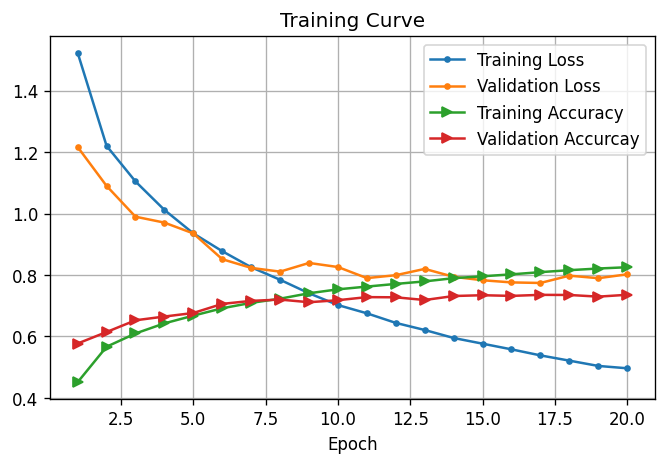

In [53]:
plot_training_curve(pd.DataFrame(history_4.history))

--- Adding an extra dropout layer has a positive effect. Now changing the hyperparameters of layers might be helpful.

Experimental Model:

--- Going under trial and error process

In [64]:
tf.random.set_seed(42)

cnn_x = keras.Sequential([
    layers.Conv2D(filters = 30, kernel_size = 3, padding = 'same', input_shape = (32, 32, 3), activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Conv2D(filters = 50, kernel_size = 2, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(pool_size = 2),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(800, activation = 'relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation = 'softmax')
])

cnn_x.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = 'accuracy'
)

history_x = cnn_x.fit(X_train_scaled, y_train, epochs = 20, validation_data = (X_val_scaled, y_val))

Epoch 1/20
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4660 - accuracy: 0.4697 - val_loss: 1.1410 - val_accuracy: 0.5974
Epoch 2/20
1407/1407 [==============================] - 6s 4ms/step - loss: 1.1600 - accuracy: 0.5874 - val_loss: 0.9922 - val_accuracy: 0.6578
Epoch 3/20
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0256 - accuracy: 0.6363 - val_loss: 0.9118 - val_accuracy: 0.6830
Epoch 4/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9339 - accuracy: 0.6699 - val_loss: 0.9502 - val_accuracy: 0.6728
Epoch 5/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8539 - accuracy: 0.7031 - val_loss: 0.8447 - val_accuracy: 0.7072
Epoch 6/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7923 - accuracy: 0.7198 - val_loss: 0.7926 - val_accuracy: 0.7238
Epoch 7/20
1407/1407 [==============================] - 6s 4ms/step - loss: 0.7405 - accuracy: 0.7395 - val_loss: 0.7627 - val_accuracy:

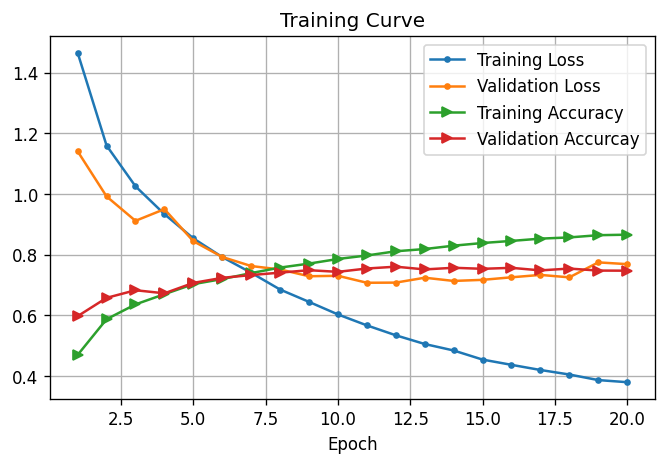

In [65]:
plot_training_curve(pd.DataFrame(history_x.history))